# Random Forest Multivariado - CS:GO Dataset
Este notebook limpia los datos, entrena un modelo Random Forest y visualiza los resultados.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from sklearn.tree import plot_tree

In [ ]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("csgo_ET2022.csv", sep=";")
df.head()

Saving csgo_ET2022.csv to csgo_ET2022.csv


<ipython-input-29-fe5c8ba0665b>:4: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("csgo_ET2022.csv", sep=";")


id         Map       Team  InternalTeamId  MatchId  RoundId RoundWinner  \
0  600  de_inferno  Terrorist               1        4        1       False   
1  601  de_inferno  Terrorist               1        4        1       False   
2  602  de_inferno  Terrorist               1        4        1       False   
3  603  de_inferno  Terrorist               1        4        1       False   
4  604  de_inferno  Terrorist               1        4        1       False   

  MatchWinner  Survived  AbnormalMatch  ... RoundKills RoundAssists  \
0        True     False          False  ...          0            0   
1        True     False          False  ...          0            0   
2        True     False          False  ...          0            0   
3        True     False          False  ...          0            0   
4        True      True          False  ...          0            0   

   RoundHeadshots  RoundFlankKills  RoundStartingEquipmentValue  \
0               0                0                          750   
1               0                0                          800   
2               0                0                         1000   
3               0                0                          850   
4               0                0                         1000   

   TeamStartingEquipmentValue  MatchKills  MatchFlankKills  MatchAssists  \
0                        4400           0                0             0   
1                        4400           0                0             0   
2                        4400           0                0             0   
3                        4400           0                0             0   
4                        4400           0                0             0   

  MatchHeadshots  
0              0  
1              0  
2              0  
3              0  
4              0  

[5 rows x 30 columns]

In [ ]:
# Crear una copia explícita del DataFrame para evitar warnings
df_clean = df[df["AbnormalMatch"] == False].copy()

# Procesamiento de TimeAlive
df_clean.loc[:, "TimeAlive"] = (df_clean["TimeAlive"].str.replace(".", "", regex=False))
df_clean.loc[:, "TimeAlive"] = pd.to_numeric(df_clean["TimeAlive"], errors="coerce") / 1e14
df_clean = df_clean[(df_clean["TimeAlive"] >= 15) & (df_clean["TimeAlive"] <= 155)].copy()

# Procesamiento de TravelledDistance
df_clean.loc[:, "TravelledDistance"] = df_clean["TravelledDistance"].astype(str).str.replace(",", ".", regex=False)
df_clean.loc[:, "TravelledDistance"] = df_clean["TravelledDistance"].str.replace(".", "", regex=False)
df_clean.loc[:, "TravelledDistance"] = pd.to_numeric(df_clean["TravelledDistance"], errors="coerce") / 1e15

# Eliminación de outliers en RoundStartingEquipmentValue
Q1 = df_clean["RoundStartingEquipmentValue"].quantile(0.25)
Q3 = df_clean["RoundStartingEquipmentValue"].quantile(0.75)
IQR = Q3 - Q1
df_clean = df_clean[
    (df_clean["RoundStartingEquipmentValue"] >= Q1 - 1.5 * IQR) &
    (df_clean["RoundStartingEquipmentValue"] <= Q3 + 1.5 * IQR)
].copy()

# Eliminar valores incorrectos en RoundWinner ----------------------------------

# Se cambia dato de 'False4' por 'False' al jugador correspondiente.
df_clean.loc[
    (df_clean['id'] == 629) &
    (df_clean['MatchId'] == 4) &
    (df_clean['RoundId'] == 3),
    'RoundWinner'
] = False

# Mapear los valores para corregir 'True' y 'False' como booleanos reales
df_clean['RoundWinner'] = df_clean['RoundWinner'].map({
    'True': True,
    'False': False,
    True: True,
    False: False
})

# Tratamiento de valores Nulos -------------------------------------------------

# imputar valor a nulos en columna 'MatchWinner'
df_clean.loc[
    (df_clean['id'] == 629),
    'MatchWinner'
] = False

# imputar valor a nulos en columna 'Team'
df_clean.loc[
    (df_clean['id'] == 627),
    'Team'
] = 'CounterTerrorist'

df_clean.loc[
    (df_clean['id'] == 613),
    'Team'
] = 'Terrorist'

In [ ]:
features = [
    "RoundStartingEquipmentValue",
    "TravelledDistance",
    "RoundKills",
    "RoundAssists",
    "RoundHeadshots",
    "PrimaryAssaultRifle",
    "PrimarySniperRifle",
    "PrimaryHeavy",
    "PrimarySMG",
    "PrimaryPistol",
]

df_model = df_clean[features + ["TimeAlive"]].dropna()
X = df_model[features]
y = df_model["TimeAlive"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Realizar predicciones
y_pred = rf_model.predict(X_test)

# Calcular métricas de regresión
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Métricas de evaluación del Random Forest Regressor:")
print(f"- MSE: {mse:.4f}")
print(f"- RMSE: {rmse:.4f}")
print(f"- MAE: {mae:.4f}")
print(f"- R²: {r2:.4f}")

importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
importances

Métricas de evaluación del Random Forest Regressor:
- MSE: 526.0015
- RMSE: 22.9347
- MAE: 17.8046
- R²: 0.3136


TravelledDistance              0.719098
RoundStartingEquipmentValue    0.148892
RoundKills                     0.032529
PrimaryPistol                  0.027370
RoundAssists                   0.020590
RoundHeadshots                 0.019696
PrimaryAssaultRifle            0.014708
PrimarySniperRifle             0.013078
PrimaryHeavy                   0.002173
PrimarySMG                     0.001866
dtype: float64

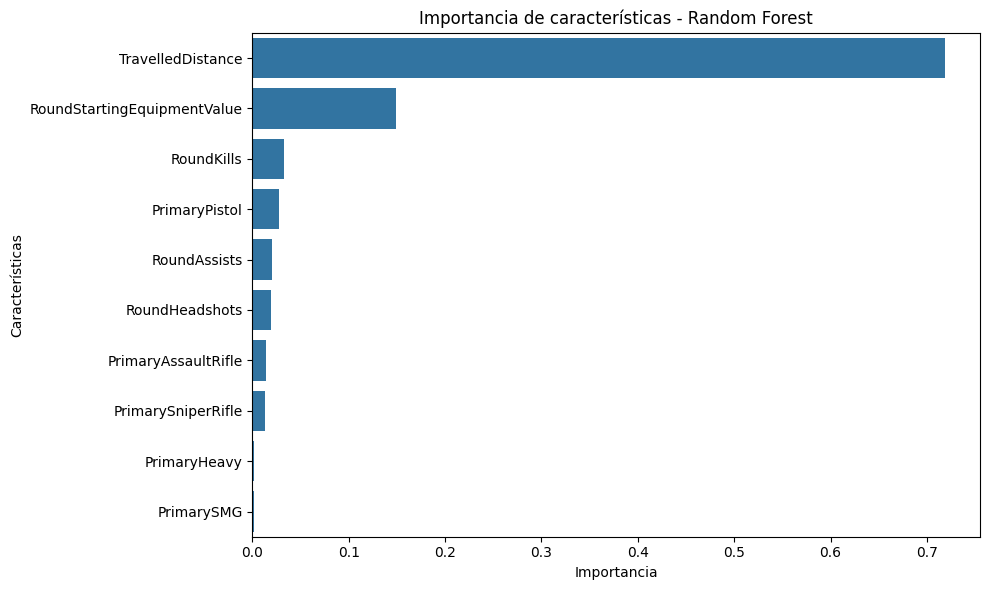

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Importancia de características - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.tight_layout()
plt.show()


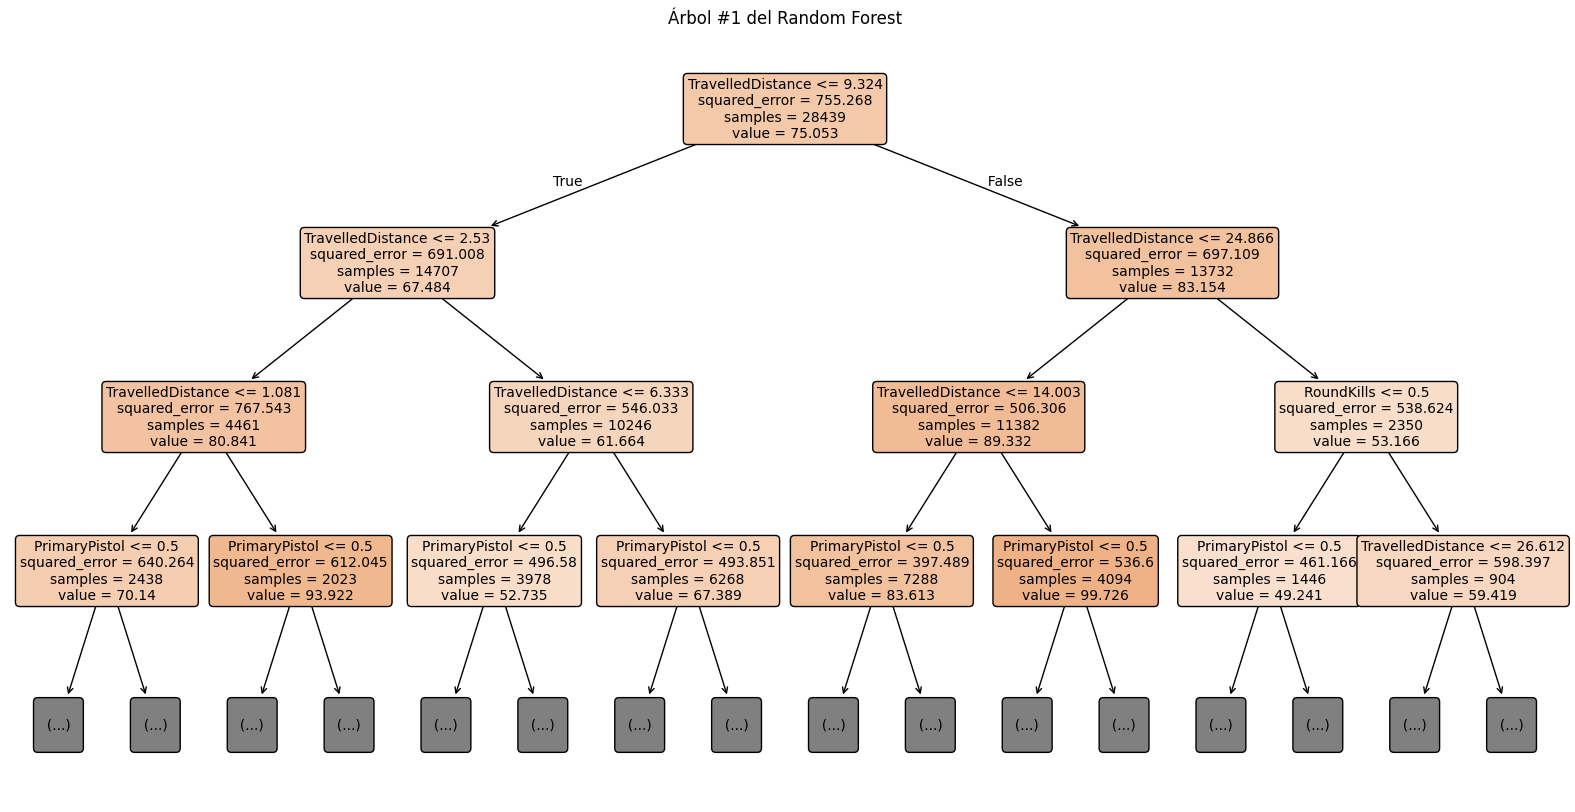

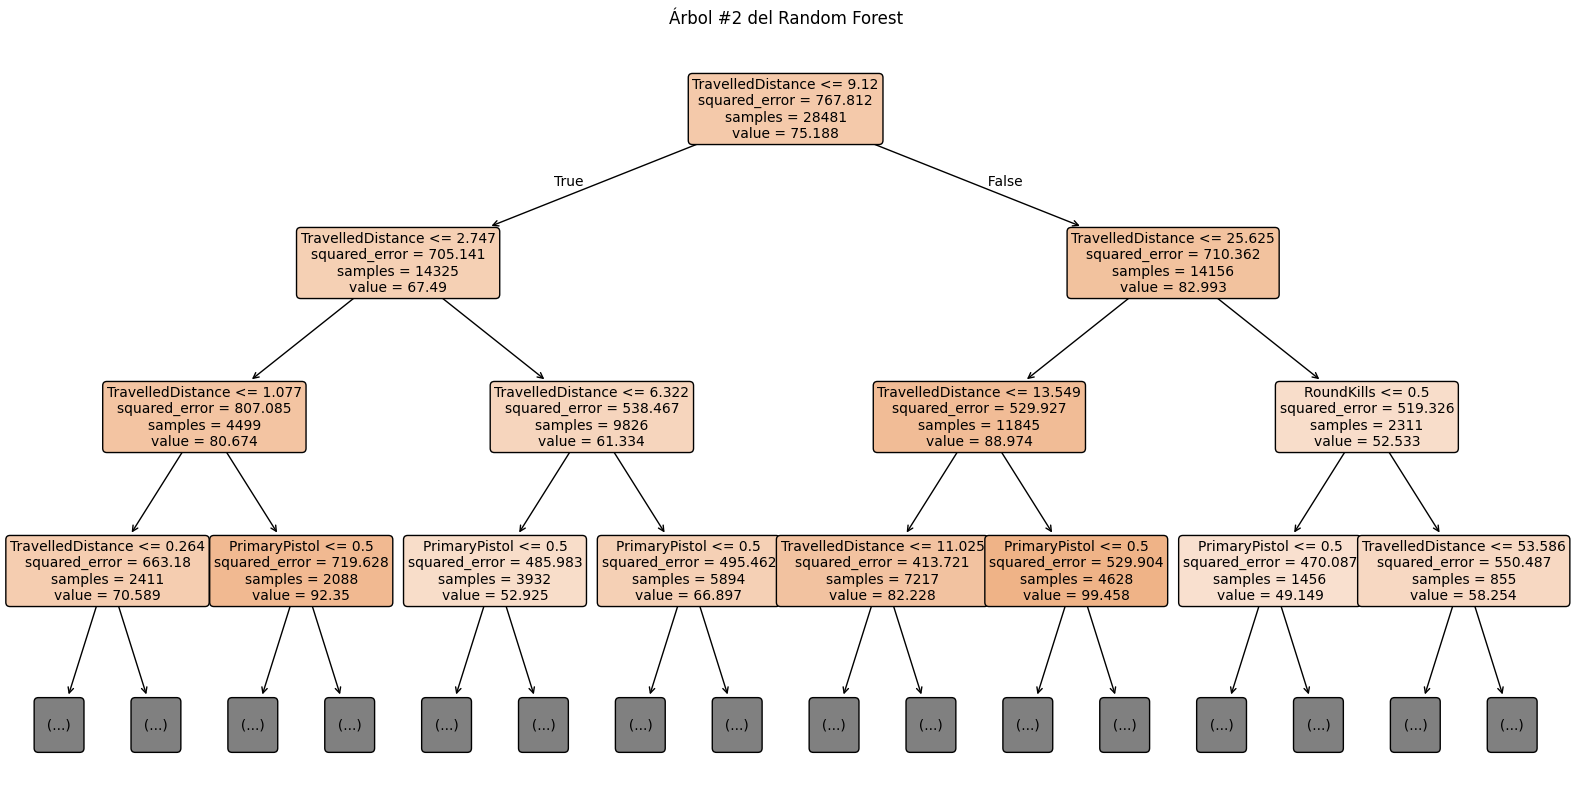

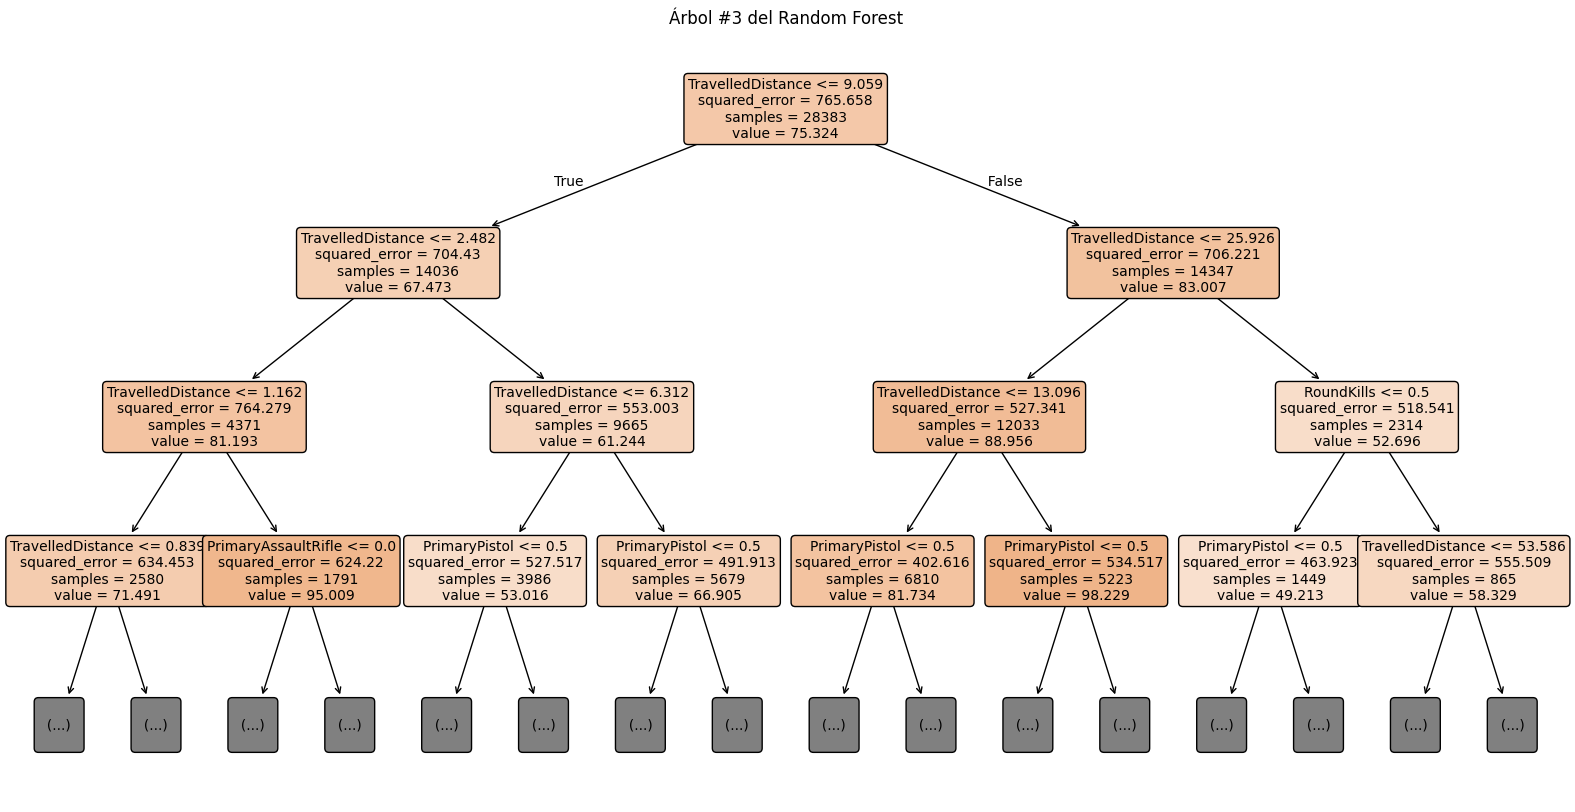

In [ ]:
for i in range(3):
    plt.figure(figsize=(20, 10))
    plot_tree(
        rf_model.estimators_[i],
        feature_names=X.columns,
        filled=True,
        rounded=True,
        max_depth=3,
        fontsize=10
    )
    plt.title(f"Árbol #{i+1} del Random Forest")
    plt.show()


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

# Calcular métricas de regresión para XGBoost
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb) # Make sure MAE is imported
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nMétricas de evaluación del XGBoost Regressor:")
print(f"- MSE: {mse_xgb:.4f}")
print(f"- RMSE: {rmse_xgb:.4f}")
print(f"- MAE: {mae_xgb:.4f}")
print(f"- R²: {r2_xgb:.4f}")


Métricas de evaluación del XGBoost Regressor:
- MSE: 455.2572
- RMSE: 21.3368
- MAE: 16.7616
- R²: 0.4059


In [ ]:
import shap

# Inicializar el explicador con un subset del training
explainer = shap.Explainer(xgb_model, X_train)

# Calcular los valores SHAP para el set de test
shap_values = explainer(X_test)


100%|===================| 11232/11243 [00:44<00:00]       

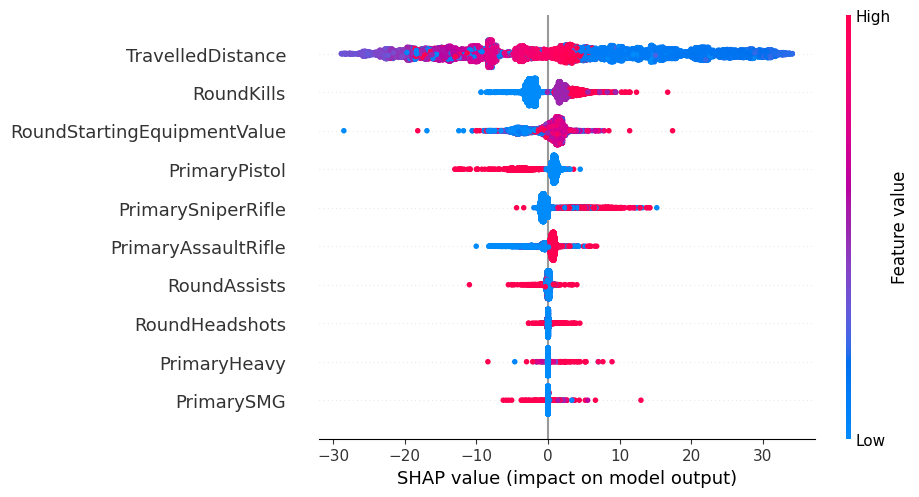

In [ ]:
shap.plots.beeswarm(shap_values, max_display=10)

# Conclusión Final

Este cuadernillo implementa y compara modelos predictivos de regresión no lineal aplicados al dataset de partidas de CS:GO, con el objetivo de explicar la variable continua `TimeAlive` a partir de múltiples características del jugador y la ronda.

## Limpieza y preprocesamiento

Se realizó una limpieza cuidadosa que incluyó:
- Conversión de variables tipo string a valores numéricos (`TimeAlive`, `TravelledDistance`).
- Eliminación de outliers mediante IQR en `RoundStartingEquipmentValue`.
- Filtrado de partidas anómalas y errores de codificación (`False4`).

Esto permitió trabajar con un dataset depurado y apto para entrenamiento de modelos robustos.

## Modelado con Random Forest

Se entrenó un modelo de `RandomForestRegressor` sobre variables técnicas del jugador. Este modelo:
- Mostró una capacidad predictiva moderada (`R²` cercano a 0.31).
- Identificó a `TravelledDistance` como el predictor más influyente, seguido por `RoundKills` y `RoundStartingEquipmentValue`.

Esto sugiere que la movilidad y el desempeño en combate están fuertemente correlacionados con la supervivencia en ronda.

## Comparación con XGBoost

El modelo de `XGBRegressor` fue entrenado sobre los mismos datos y variables. Se observó una mejora en las métricas de error y ajuste respecto a Random Forest, confirmando:
- Mejor manejo de relaciones no lineales.
- Mayor eficiencia en predicción individual.

## Interpretabilidad con SHAP

La evaluación con `SHAP` (SHapley values) permitió:
- Visualizar cómo cada feature afecta la predicción a nivel global y local.
- Confirmar que valores altos de `TravelledDistance` y `RoundKills` tienen un fuerte impacto positivo en `TimeAlive`.
- Detectar que algunas variables (como tipo de arma) tienen un impacto mucho menor.

## Conclusión crítica

- El cuadernillo demuestra correctamente que es válido usar Random Forest y XGBoost como herramientas predictivas para hipótesis de regresión, siempre que no se busquen inferencias causales.
- El uso de SHAP aporta una capa de explicabilidad crítica para interpretar resultados de modelos complejos en datasets tabulares.